In [880]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### VISUALIZE AND QUANTIZE 

In [881]:
"""
Cell Purpose: Load all the gesture training data and append it to two variables

Variable: 
- time_data: "Specific times that acceleration was observed"
- acceleration_data: "Specific linear and angular acceleration at specific times"

Variable Shapes: 
- time_data = (4111, 1) = (# instances, 1 Time)
- acceleration_data = (4111, 6) = (# Instances, 6 acceleration columns)
"""

def load_file(file_name):
    return np.loadtxt(file_name)

fname = "Data/ECE5242Proj2_train_additional-selected/wave31.txt"
gesture_data = load_file(fname)
time_data = gesture_data[:, 0][:, np.newaxis]
acceleration_data = gesture_data[:, 1:]

# # Append all of the gesture data which we will discretize the data 
# for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
#     fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
#     path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
#     gesture_data = load_file(path)

#     if i == 0:
#         time_data = gesture_data[:, 0][:, np.newaxis]
#         acceleration_data = gesture_data[:, 1:]
#     else:
#         time_data = np.row_stack((time_data, gesture_data[:, 0][:, np.newaxis])) # NOT SURE IF THIS IS CORRECT
#         acceleration_data = np.row_stack((acceleration_data, gesture_data[:, 1:]))

print(acceleration_data.shape, time_data.shape)

(441, 6) (441, 1)


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


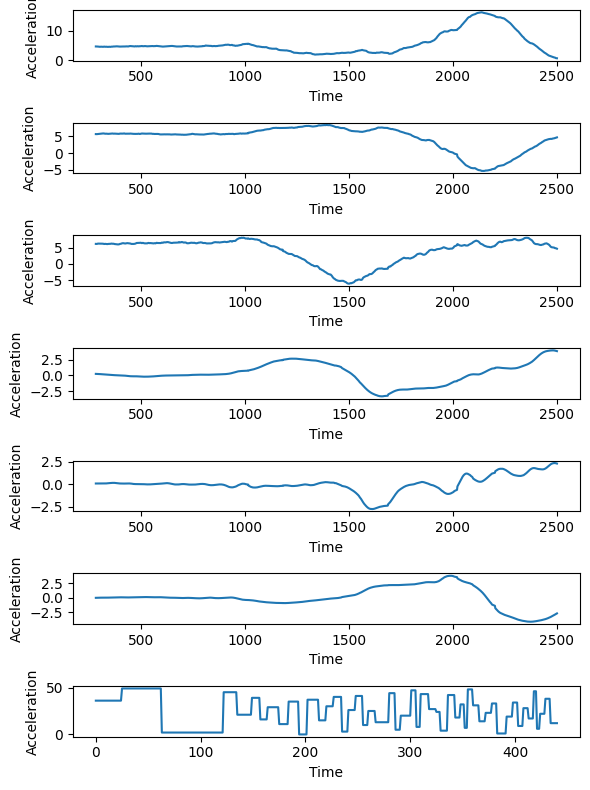

In [882]:
"""
Cell Purpose: Use KMeans to discretize the raw sensor data which is seen in the last graph. 

Variables:
- num_of_clusters = "using kmeans to create clusters which brings down the number of dimensions from 6 to 1"
- M = "discrete observations or KMeans clusters"
- O = "Observations"

Variable Shapes:
- num_of_clusters = float

"""
def plot_continuous_discrete(clusters, time, acceleration):
    # Plot the data
    fig, axs = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(6, 8))

    # Plot each channel in a separate subplot
    for i, ax in enumerate(axs):
        if i < 6:
            ax.plot(time, acceleration[:, i])
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
        else:
            ax.plot(clusters)
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')

    # # Adjust the layout and spacing of the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


M = 50
O = KMeans(n_clusters=M).fit_predict(acceleration_data)
plot_continuous_discrete(O, time_data, acceleration_data)

## IMPLEMENT HMM

In [883]:
"""
Cell Purpose: Initialize the model parameters

Variables:
- N: Number of states
- M: Number of observation classes or clusters
- A: Transition Matrix
- pi: Initial probability we are in a a specific state

Variable Shapes
- N: float
- A: (Number of states, number of states)
- pi: (N, 1)
"""

def init_a_matrix(N):
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 0.5
        if i + 1 < N:
            A[i + 1, i] = 0.5
    
    A[0, -1] = 0.5 # This is to make sure it can transition to another state
    return A

def init_pi_matrix(N):
    pi = np.zeros((N))
    pi[0] = 1
    return pi

def init_b_matrix(N, M):
    arr = np.random.rand(N, M)
    arr = arr / np.sum(arr, axis=1, keepdims=True)
    return arr

N = 10
A = init_a_matrix(N)
B = init_b_matrix(N, M)
pi = init_pi_matrix(N)

print("\nA: ", A)
print("\nB: ", B)
print("\nPi: ", pi)
# print("\nO: ", O)


A:  [[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]

B:  [[1.94032001e-02 6.61712401e-04 2.71671518e-03 2.67525167e-02
  1.14102513e-02 4.01165516e-02 3.29019489e-03 4.25662281e-02
  9.99369566e-03 1.48708580e-02 3.75725967e-02 4.75502455e-02
  2.00456508e-02 2.10152640e-03 5.50659031e-03 4.19359721e-03
  1.41995356e-02 2.51627187e-02 6.28746059e-03 1.14772603e-03
  4.19045167e-02 1.20120298e-02 2.31129432e-02 3.85311342e-02
  4.05621541e-02 3.16950602e-02 4.21505734e-02 6.20920322e-03
  3.68003446e-02 4.45387561e-02 1.58150041e-02 7.46815611e-03
  1.53335764e-02 3.00577775e-02 7.36745670e-03 2.42076577e-02
 

In [905]:
"""
Variables:
- O: "Each observation is assigned a cluster number which also indicates"
- B: "Observation/Emission Matrix"
- pi: "Initial state probabilities"
- Alpha: "Probability you are in state j given a sequence of observations up to t-1"
- Beta: "Probability of seeing a sequence of future observations"
- A: "Transition Matrix"
- Gamma: "Probability of being in state i at time T"
- xi: "Probability of going from state i to state j given observation sequence"
- c: "Scaling factor to prevent underflow"


Variable Shapes:
- O: (4111,) = (Gesture Instances, 1)
- B: (10 , 50) = (Number of hidden states, Number of clusters)
- pi: (10, 1) = (Number of hidden states, 1)
- Alpha: ( Length of the observation sequence, Number of hidden states)
- Beta: (Length of observation sequence, Number of hidden states)
- A: (Number of hidden states, number of hidden states))
- Gamma: (Number of hidden states, Length of observation sequence)
- xi: (Number of hidden states, Number of hidden states, Length of observation sequence)
- c: (Length of observation sequence)
"""

class HMM:
    def __init__(self, N, M, A, B, pi, O):
        self.N = N
        self.M = M
        self.A = A
        self.B = B
        self.pi = pi
        self.O = O
        self.T = len(O)
        
    def forward(self):
        alpha = np.zeros((self.T, self.N))
        c = np.zeros(self.T)
        
        # Base case
        alpha[0, :] = self.pi.flatten() * self.B[:, self.O[0]]
        c[0] = 1 / np.sum(alpha[0])
        alpha[0, :] *= c[0]
        
        # Recursive case
        for t in range(1, self.T):
            alpha[t, :] = np.sum(alpha[t-1, :].reshape((-1, 1)) * self.A, axis=0) * self.B[:, self.O[t]] # Double check reshapes if it doesn't work
            c[t] = 1 / np.sum(alpha[t])
            alpha[t, :] *= c[t]
            
        return alpha, c
        
    def backward(self, c):
        beta = np.zeros((self.T, self.N))
        
        # Base case
        beta[-1, :] = 1
        beta[-1, :] *= c[-1]
        
        # Recursive case
        for t in range(self.T-2, -1, -1):
            beta[t, :] = np.sum(self.A * self.B[:, self.O[t+1]] * beta[t+1, :], axis=1)
            beta[t, :] *= c[t]
            
        return beta
    
    def calculate_gamma(self, alpha, beta):
        gamma = alpha * beta
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        return gamma

    def calculate_xi(self, alpha, beta):
        xi = np.zeros((self.T-1, self.N, self.N))
        for t in range(self.T-1):
            xi[t, :, :] = alpha[t, :].reshape((-1, 1)) * self.A * self.B[:, self.O[t+1]].reshape((1, -1)) * beta[t+1, :].reshape((1, -1)) # Double check reshapes if it doesn't work
            xi[t, :, :] /= np.sum(xi[t, :, :])
        return xi
    
    def adjust_a(self, xi):
            A_hat = np.sum(xi, axis=0)
            A_hat /= np.sum(A_hat, axis=1, keepdims=True)
            return A_hat
    
    def adjust_b(self, gamma):
        B_hat = np.zeros((self.N, self.M))
        for j in range(self.N):
            for k in range(self.M):
                mask = (self.O == k)
                B_hat[j, k] = np.sum(gamma[mask, j]) / np.sum(gamma[:, j])
        return B_hat
    
    def adjust_pi(self, gamma):
        pi_hat = gamma[0, :]
        pi_hat /= np.sum(pi_hat)
        return pi_hat

    def Baum_Welsh(self):
        # Forward and Backward
        alpha, c = self.forward()
        beta = self.backward(c)
        
        # E Step
        gamma = self.calculate_gamma(alpha, beta)
        xi = self.calculate_xi(alpha, beta)
        
        # M Step
        A_hat = self.adjust_a(xi)
        B_hat = self.adjust_b(gamma)
        pi_hat = self.adjust_pi(gamma)
        
        # Calculate likelihood
        log_likelihood = -np.sum(np.log(c))

        return A_hat, B_hat, pi_hat, log_likelihood


Epoch:  0

Log likelihood:  -1714.1161481782422

Epoch:  1

Log likelihood:  -1258.8825701317114

Epoch:  2

Log likelihood:  -1064.4508481097746

Epoch:  3

Log likelihood:  -1040.410916398967

Epoch:  4

Log likelihood:  -1033.0765070776545

Epoch:  5

Log likelihood:  -1029.6293590543999

Epoch:  6

Log likelihood:  -1026.931717671919

Epoch:  7

Log likelihood:  -1024.0762138318878

Epoch:  8

Log likelihood:  -1021.8246612133605

Epoch:  9

Log likelihood:  -1020.3511158834824


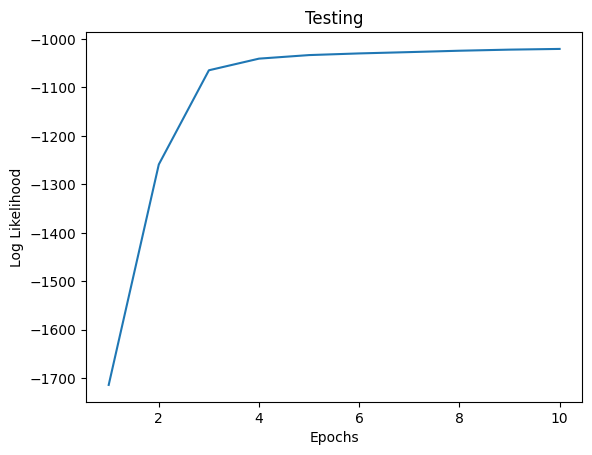

(array([[0.71302652, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.28697348],
        [0.30861079, 0.69138921, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.18473209, 0.81526791, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.29774129, 0.70225871, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.30453964, 0.69546036,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.19890652,
         0.80109348, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.13724191, 0.86275809, 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [907]:
def plot_likelihoods(gesture_name, num_epochs, likelihoods):
    # Create a list of epoch numbers
    epochs = range(1, num_epochs+1)
    
    # Create a figure for subplots
    fig, axs = plt.subplots()
    axs.plot(epochs, likelihoods)
    axs.set_title(gesture_name)
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Log Likelihood')

    plt.show()


def train_model(gesture_name, epochs, N, M, A, B, pi, O):
    model = HMM(N, M, A, B, pi, O)
    log_likelihood_list = []
    for epoch in range(epochs):
        # print("Before A: ", model.A)
        # print("Before B: ", B)
        # print("pi: ", pi)
        A, B, pi, likelihood = model.Baum_Welsh()
        # print("After A: ", A)
        # print("After B: ", B)
        # print("pi: ", pi)
        model.A = A
        model.B = B
        model.pi = pi
        log_likelihood_list.append(likelihood)
        print("\nEpoch: ", epoch)
        print("\nLog likelihood: ", likelihood)
    
    plot_likelihoods(gesture_name, epochs, log_likelihood_list)
    return model.A, model.B, model.pi

# TESTING DATASET
# N = 2
# M = 2
# A = np.array([[0.5,0.5],[0.5,0.5]])
# B = np.array([[0.5,0.5],[0.5,0.5]])
# pi = init_pi_matrix(N)
# O = np.array([0,0,0,1,1,1])

train_model("Testing", 10, N, M, A, B, pi, O)

## TESTING

In [ ]:
def save_parameters(gesture_name, A, B, pi):
    # Create directory if it does not exist
    directory = f'Data/Saved_Parameters/{gesture_name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save parameters to file
    np.save(os.path.join(directory, 'A.npy'), A)
    np.save(os.path.join(directory, 'B.npy'), B)
    np.save(os.path.join(directory, 'pi.npy'), pi)

def train_all_models(num_epochs, N, M):
    for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
        # Load the data for each gesture
        fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
        file_name, file_extension = os.path.splitext(fname)
        path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
        gesture_data = load_file(path)
        time_data = gesture_data[:, 0][:, np.newaxis]
        acceleration_data = gesture_data[:, 1:]

        # Discretize the gesture data using kmeans
        O = KMeans(n_clusters=M).fit_predict(acceleration_data)

        # Initialize parameters
        A = init_a_matrix(N)
        B = init_b_matrix(N, M)
        pi = init_pi_matrix(N)

        # Train each model
        A, B, pi = train_model(file_name, num_epochs, N, M, A, B, pi, O)

        # Save model parameters
        save_parameters(file_name, A, B, pi)

train_all_models(10, 10, 50)

In [911]:
def load_parameters(gesture_name):
    directory = f'Data/Saved_Parameters/{gesture_name}'

    # Load saved parameters
    A = np.load(os.path.join(directory, 'A.npy'))
    B = np.load(os.path.join(directory, 'B.npy'))
    pi = np.load(os.path.join(directory, 'pi.npy'))

    return A, B, pi

In [916]:
def test_models():
    M = 50
    N = 10

    for j in range(len(os.listdir("Data/ECE5242Proj2-test-selected/"))):
        # Load and discretize the test data
        test_fname = os.listdir("Data/ECE5242Proj2-test-selected/")[j]
        test_file_name, file_extension = os.path.splitext(test_fname)
        path = os.path.join("Data/ECE5242Proj2-test-selected/", test_fname)
        gesture_data = load_file(path)
        time_data = gesture_data[:, 0][:, np.newaxis]
        acceleration_data = gesture_data[:, 1:]

        # Discretize the test data using kmeans
        O = KMeans(n_clusters=M).fit_predict(acceleration_data)
        print(f"{test_file_name} Predictions:")
        log_likelihoods = []
        
        for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
            # Load the trained lambda parameters for each gesture
            fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
            file_name, file_extension = os.path.splitext(fname)
            A, B, pi = load_parameters(file_name)

            # Run through forward pass to get predictions
            model = HMM(N, M, A, B, pi, O)
            _, c = model.forward()
            log_likelihood = -np.sum(np.log(c))
            log_likelihoods.append((file_name, log_likelihood))
        
        print(log_likelihoods)
        sorted_list = sorted(log_likelihoods, key=lambda x: x[1], reverse=True)
        print("My Prediction: ", sorted_list[0])
        print("\nTop 3 predictions: ", sorted_list[:3])

test_models()

/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test7 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: overflow encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:47: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] = np.sum(alpha[

test6 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test4 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test5 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', -11574.597598699718), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', -11574.597598699718)]
test1 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329

test2 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test3 Predictions:
[('circle31', -15664.737399726779), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', nan)]
My Prediction:  ('circle31', -15664.737399726779)

Top 3 predictions:  [('circle31', -15664.737399726779), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


test8 Predictions:
[('circle31', nan), ('beat3_31', nan), ('inf31', nan), ('beat4_31', nan), ('eight31', nan), ('wave31', -4225.185886199175)]
My Prediction:  ('circle31', nan)

Top 3 predictions:  [('circle31', nan), ('beat3_31', nan), ('inf31', nan)]


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  c[t] = 1 / np.sum(alpha[t])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:49: RuntimeWarning: invalid value encountered in multiply
  alpha[t, :] *= c[t]
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  c[0] = 1 / np.sum(alpha[0])
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/1484656362.py:43: RuntimeWarning: invalid value encountered in multiply
  alpha[0, :] *= c[0]
